 sqlite:///my.db# Plotting large datasets


```{tip}
Try this locally:

~~~
pip install k2s -U && k2s get ploomber/jupysql/master/examples/plot.ipynb
~~~

```


*New in version 0.4.4*

```{note}
This is a beta feature, please [join our community](https://ploomber.io/community) and let us know what plots we should add next!
```

Using libraries like `matplotlib` or `seaborn`, requires fetching all the data locally, which quickly can fill up the memory in your machine. JupySQL runs computations in the warehouse/database to drastically reduce memory usage and runtime.

As an example, we are using a sales database from a record store. We’ll find the artists that have produced the largest number of Rock and Metal songs.

Let’s load some data:

In [1]:
import urllib.request
from pathlib import Path
from sqlite3 import connect

if not Path('my.db').is_file():
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite"
    urllib.request.urlretrieve(url, 'my.db')

Now, let's initialize the extension so we only retrieve a few rows.

Please note that `jupysql` and `memory_profiler` need o be installed.

In [2]:
%load_ext autoreload
%autoreload 2

%load_ext sql
%load_ext memory_profiler

We'll be using a sample dataset that contains information on music tracks:

In [3]:
%%sql sqlite:///my.db
SELECT * FROM "Track" LIMIT 3

Done.


TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Hoffman",230619,3990994,0.99


The `Track` table contains 3503 rows:

In [5]:
%%sql
SELECT COUNT(*) FROM "Track"

 * sqlite:///my.db
Done.


COUNT(*)
3503


## Boxplot

```{note}
To use `plot.boxplot`, your SQL engine must support:

`percentile_disc(...) WITHIN GROUP (ORDER BY ...)`

[Snowflake](https://docs.snowflake.com/en/sql-reference/functions/percentile_disc.html),
[Postgres](https://www.postgresql.org/docs/9.4/functions-aggregate.html),
[DuckDB](https://duckdb.org/docs/sql/aggregates), and others support this.
```

In [6]:
from sql import plot
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [ ]:
%%memit
plot.boxplot('Track', 'Milliseconds')

Note that the plot consumes only a few MiB of memory (increment), since most of the processing happens in the SQL engine. Furthermore, you'll also see big performance improvements if using a warehouse like Snowflake, Redshift or BigQuery, since they can process large amounts of data efficiently.

## Histogram

peak memory: 185.03 MiB, increment: 3.95 MiB


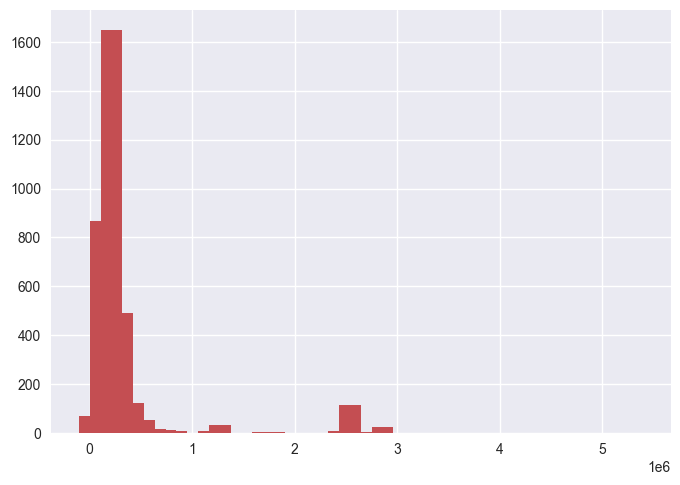

In [9]:
%%memit
plot.histogram('Track', 'Milliseconds', bins=50)

## Benchmark

For comparison, let's see what happens if we compute locally:

In [10]:
from IPython import get_ipython

def fetch_data():
    """
    Only needed to enable %%memit, this is the same as doing
    res = %sql SELECT "Milliseconds" FROM "Track"
    """
    ip = get_ipython()
    return ip.run_line_magic('sql', 'SELECT "Milliseconds" FROM "Track"')

Fetching data consumes a lot of memory:

In [11]:
%%memit
res = fetch_data()

 * sqlite:///my.db
Done.
 * sqlite:///my.db
Done.
 * sqlite:///my.db
Done.
peak memory: 190.41 MiB, increment: 0.53 MiB


Plotting functions also increase memory usage:

peak memory: 191.16 MiB, increment: 0.72 MiB


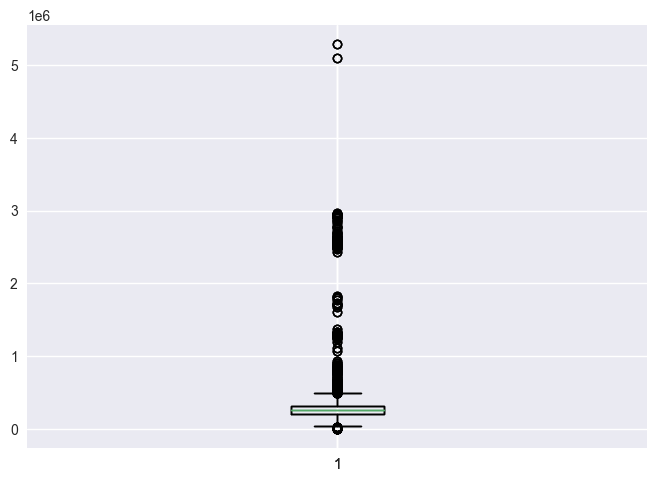

In [12]:
%%memit
_ = plt.boxplot(res.DataFrame().Milliseconds)

peak memory: 195.55 MiB, increment: 1.70 MiB


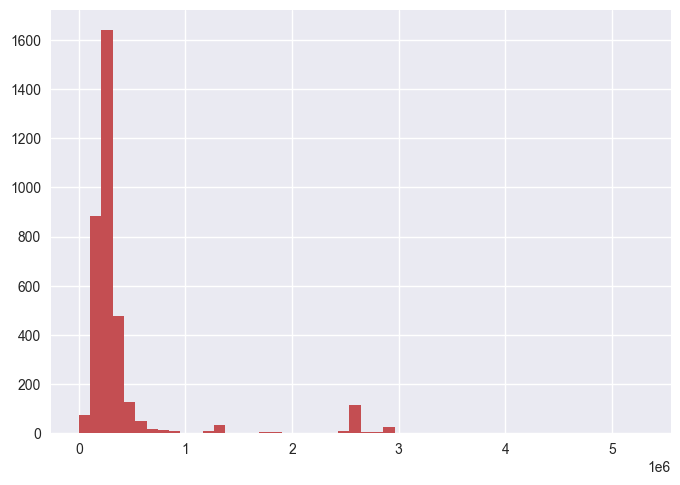

In [13]:
%%memit
_ = plt.hist(res.DataFrame().Milliseconds, bins=50)

The memory consumption is a lot higher!